# RNA Seq Analysis

This section is to be completed after the reads have been quantified using salmon

In [1]:
library(tximport)
library(dplyr)
library(ggplot2)
library(DESeq2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attachi

In [2]:
files <- list.files(path = "~/rna-seq-tutorial/raw-seq-data", pattern = ".sf", full.names = TRUE, recursive = TRUE)

samp_dirs <- basename(dirname(files))
names(files) <- sub("_quant$", "", samp_dirs)

In [3]:
gtf <- rtracklayer::import("~/rna-seq-tutorial/reference/gencode.v45.basic.annotation.gtf.gz")

In [4]:
head(gtf)

GRanges object with 6 ranges and 22 metadata columns:
      seqnames      ranges strand |   source       type     score     phase
         <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1 11869-14409      + |   HAVANA gene              NA      <NA>
  [2]     chr1 11869-14409      + |   HAVANA transcript        NA      <NA>
  [3]     chr1 11869-12227      + |   HAVANA exon              NA      <NA>
  [4]     chr1 12613-12721      + |   HAVANA exon              NA      <NA>
  [5]     chr1 13221-14409      + |   HAVANA exon              NA      <NA>
  [6]     chr1 12010-13670      + |   HAVANA gene              NA      <NA>
                gene_id              gene_type   gene_name       level
            <character>            <character> <character> <character>
  [1] ENSG00000290825.1                 lncRNA     DDX11L2           2
  [2] ENSG00000290825.1                 lncRNA     DDX11L2           2
  [3] ENSG00000290825.1                 lncRNA     DDX

Convert it into a df with tidyverse.

In [5]:
gtf_df <- as.data.frame(gtf)

This file is used to import the salmon output to summarize the counts from transcript level to gene level.

In [6]:
tx2gene <- gtf_df %>%
        filter(type == "transcript") %>%
        select(transcript_id, gene_id)

This file is used to map the ENSEMBL gene id to gene symbols in the DESeq2 results

In [7]:
gene_name_map <- gtf_df %>% 
        filter(type == "gene") %>% 
        select(gene_id, gene_name)

Use tx2gene to summarize to gene level.

In [8]:
txi.salmon <- tximport(files, type = "salmon", tx2gene = tx2gene)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 


transcripts missing from tx2gene: 134744

summarizing abundance

summarizing counts

summarizing length



Read in the meta data that we downloaded earlier. As you may have noticid already,the metadata for our dataset is more messy than we would like as there are not individual columns for treatment group etc that would allow us to easily use the file. Therefore, we need to make a dataframe that meets our requirements using the data we have.

In [9]:
ena <- read.delim("/home/anbennett2/rna-seq-tutorial/filereport_read_run_SRP033351_tsv-2.txt", 
                  sep = "\t", header = TRUE, stringsAsFactors = FALSE)

Extract the column names from the counts matrix in the txi.salmon object.

In [10]:
sample_ids <- colnames(txi.salmon$counts)

Perform a sanity check to ensure that every sample ID in the count matrix is inside the metadata file.

In [11]:
stopifnot(all(sample_ids %in% ena$run_accession))

creates a new metadata data frame 'ena_aligned' where the rows are reordered to match the order of sample_ids from your count matrix.

In [12]:
ena_aligned <- ena[match(sample_ids, ena$run_accession), ]

Create a vector which assigns a treatment group to each sample based on sample_title in the metadata

In [13]:
condition <- case_when(
  grepl("_untreated$", ena_aligned$sample_title) ~ "untreated",
  grepl("_Alb_Dex$", ena_aligned$sample_title) ~ "albuterol_dexamethasone", 
  grepl("_Alb$", ena_aligned$sample_title) ~ "albuterol",
  grepl("_Dex$", ena_aligned$sample_title) ~ "dexamethasone",
  TRUE ~ NA_character_
)

Create a vector called donor which extracts the part of each sample_title before the first underscore. This is what we will use for grouping samples by donor in downstream analysis.

In [14]:
donor <- sub("_.*$", "", ena_aligned$sample_title)

Create a metadata data frame called meta for downstream analysis

In [15]:
meta <- data.frame(
  condition = factor(condition, 
                    levels = c("untreated", "albuterol", "dexamethasone", "albuterol_dexamethasone")),
  donor = factor(donor),
  row.names = ena_aligned$run_accession,
  stringsAsFactors = FALSE
)

Take a look at the metadata we just creat4ed

In [16]:
print(meta)
table(meta$condition)
table(meta$donor)

                         condition   donor
SRR1039508               untreated  N61311
SRR1039509           dexamethasone  N61311
SRR1039510               albuterol  N61311
SRR1039511 albuterol_dexamethasone  N61311
SRR1039512               untreated N052611
SRR1039513           dexamethasone N052611
SRR1039514               albuterol N052611
SRR1039515 albuterol_dexamethasone N052611
SRR1039516               untreated N080611
SRR1039517           dexamethasone N080611
SRR1039518               albuterol N080611
SRR1039519 albuterol_dexamethasone N080611
SRR1039520               untreated N061011
SRR1039521           dexamethasone N061011
SRR1039522               albuterol N061011
SRR1039523 albuterol_dexamethasone N061011



              untreated               albuterol           dexamethasone 
                      4                       4                       4 
albuterol_dexamethasone 
                      4 


N052611 N061011 N080611  N61311 
      4       4       4       4 

In [17]:
stopifnot(identical(rownames(meta), colnames(txi.salmon$counts)))
stopifnot(!any(is.na(meta$condition)))

Now we willm use DeSeq2 to perform the differential expression analysis.

In [18]:
dds <- DESeqDataSetFromTximport(txi.salmon, meta, ~ condition)

dds$condition <- relevel(dds$condition, ref = "untreated")

dds <- DESeq(dds)

res <- results(dds, contrast = c("condition", "untreated", "dexamethasone"))

res

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition untreated vs dexamethasone 
Wald test p-value: condition untreated vs dexamethasone 
DataFrame with 62742 rows and 6 columns
                      baseMean log2FoldChange     lfcSE       stat    pvalue
                     <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSG00000000003.16 791.3682232       0.375555  0.239352    1.56905 0.1166367
ENSG00000000005.6    0.0528122       0.000000  4.327943    0.00000 1.0000000
ENSG00000000419.14 514.6329083      -0.207617  0.110517   -1.87859 0.0603007
ENSG00000000457.14 296.0506944       0.142772  0.112589    1.26809 0.2047672
ENSG00000000460.17  51.0294445      -0.404865  0.366729   -1.10399 0.2695979
...                        ...            ...       ...        ...       ...
ENSG00000293556.1    0.0525095       0.000000   4.32794  0.0000000  1.000000
ENSG00000293557.1    0.1809878       0.000000   4.32794  0.0000000  1.000000
ENSG00000293558.1    0.0000000             NA        NA         NA     

Plot the counts and p-vallue on a chart to check how they look and determine if its what we expect.

Warning message:
“Removed 22511 rows containing non-finite outside the scale range
(`stat_bin()`).”


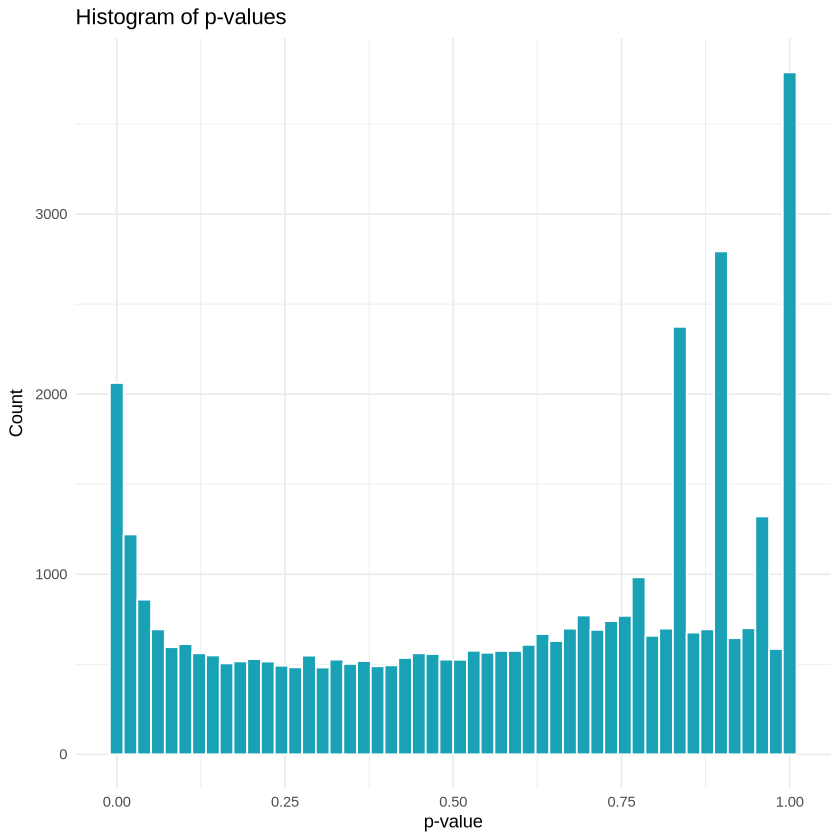

In [19]:
res %>% 
  as.data.frame() %>%
  arrange(padj) %>%
  ggplot(aes(x = pvalue)) +
  geom_histogram(fill = "#19a1b6ff", color = "white", bins = 50) +
  labs(
    title = "Histogram of p-values",
    x = "p-value",
    y = "Count"
  ) +
  theme_minimal()

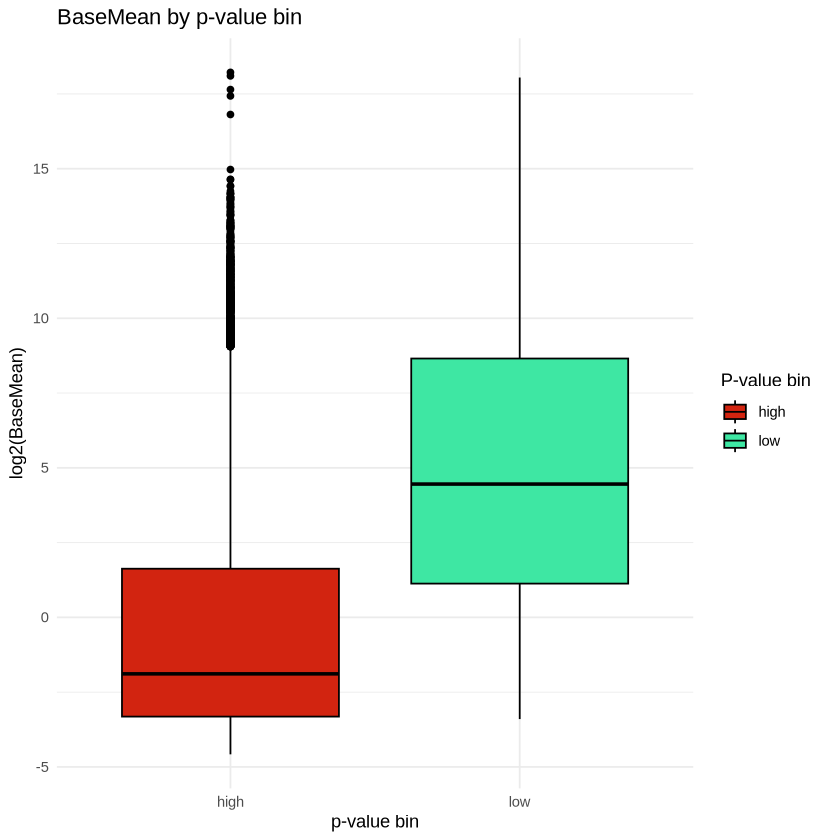

In [20]:
res %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = "gene_id") %>%
  filter(!is.na(pvalue)) %>%
  mutate(pvalue_bin = if_else(pvalue > 0.75, "high", "low")) %>%
  ggplot(aes(x = pvalue_bin, y = log2(baseMean), fill = pvalue_bin)) +
  geom_boxplot(color = "#000000ff") +  # Default shows whiskers
  scale_fill_manual(values = c("low" = "#3ee7a3ff", "high" = "#d22410ff")) +
  labs(
    title = "BaseMean by p-value bin",
    x = "p-value bin",
    y = "log2(BaseMean)",
    fill = "P-value bin"
  ) +
  theme_minimal()

In [21]:
# counts across 4 samples should be greater than 10, this number is subjective
dds <- dds[rowSums(counts(dds)) > 10,]

dds <- DESeq(dds)

res <- results(dds, contrast = c("condition", "untreated", "dexamethasone"))


using pre-existing normalization factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Warning message:
“Removed 91 rows containing non-finite outside the scale range (`stat_bin()`).”


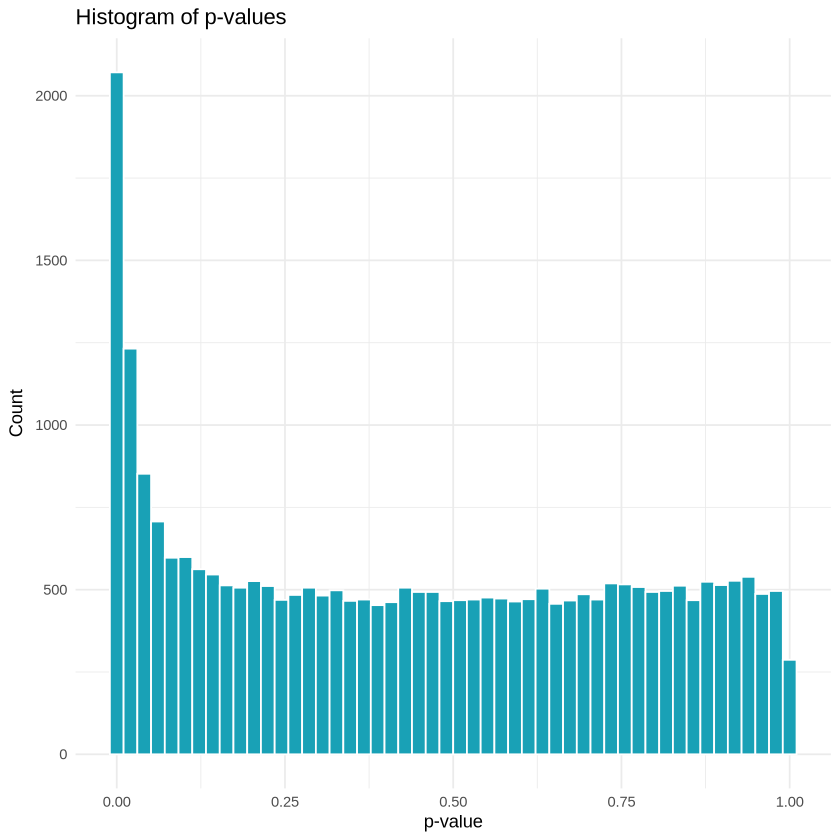

In [22]:
res %>% 
  as.data.frame() %>%
  arrange(padj) %>%
  ggplot(aes(x = pvalue)) +
  geom_histogram(fill = "#19a1b6ff", color = "white", bins = 50) +
  labs(
    title = "Histogram of p-values",
    x = "p-value",
    y = "Count"
  ) +
  theme_minimal()

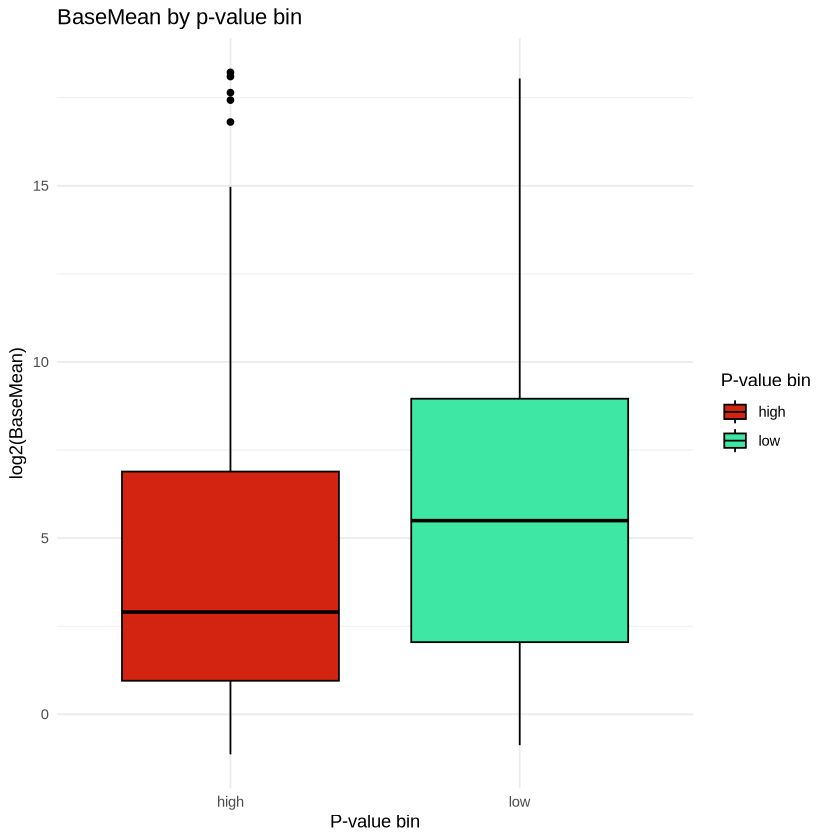

In [23]:
res %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = "gene_id") %>%
  filter(!is.na(pvalue)) %>%
  mutate(pvalue_bin = if_else(pvalue > 0.75, "high", "low")) %>%
  ggplot(aes(x = pvalue_bin, y = log2(baseMean), fill = pvalue_bin)) +
  geom_boxplot(color = "#000000ff") +  # Default shows whiskers
  scale_fill_manual(values = c("low" = "#3ee7a3ff", "high" = "#d22410ff")) +
  labs(
    title = "BaseMean by p-value bin",
    x = "P-value bin",
    y = "log2(BaseMean)",
    fill = "P-value bin"
  ) +
  theme_minimal()

In [24]:
add_gene_name<- function(res){
  df<- as.data.frame(res) %>%
    tibble::rownames_to_column(var = "gene_id") %>%
    left_join(gene_name_map) %>%
    arrange(padj, abs(log2FoldChange))
  return(df)
}


add_gene_name(res) %>%
        head()

Joining with `by = join_by(gene_id)`


,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSG00000179094.16,866.20625,-3.1960307,0.5487791,-5.823893,5.749226e-09,4.754675e-05,PER1
2,ENSG00000109906.15,1130.36863,-8.1880003,1.4063867,-5.822012,5.814338e-09,4.754675e-05,ZBTB16
3,ENSG00000198517.10,655.52778,-0.7390099,0.1330988,-5.552343,2.818665e-08,1.445344e-04,MAFK
4,ENSG00000179593.16,69.17867,-9.5013187,1.7235518,-5.512639,3.534929e-08,1.445344e-04,ALOX15B
5,ENSG00000166401.15,405.33354,-0.6878922,0.1273192,-5.402894,6.557438e-08,2.144938e-04,SERPINB8
6,ENSG00000136051.15,1827.73757,-0.4439631,0.0844476,-5.257261,1.462164e-07,3.985616e-04,WASHC4
